In [1]:
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras import layers
import sklearn.metrics as skm
import os


2023-06-28 17:11:37.091102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the dataset
#data_path = '/Users/as274094/Documents/psf_dataset1/'
# data_path = '/gpfswork/rech/prk/uzk69cg/psf_dataset1/'
data_path = '/Users/as274094/Documents/psf_dataset2/'
dataset = np.load(data_path + 'PCA_dataset2B24.npy', allow_pickle=True)[()]

x_train = dataset['train_stars_pca']
x_val = dataset['validation_stars_pca']
x_test = dataset['test_stars_pca']
y_train = dataset['train_SEDs']
y_val = dataset['validation_SEDs']
y_test = dataset['test_SEDs']

y_train_cat = tf.keras.utils.to_categorical(y_train,num_classes = 13)
y_val_cat = tf.keras.utils.to_categorical(y_val,num_classes = 13)
y_test_cat = tf.keras.utils.to_categorical(y_test,num_classes = 13)


In [21]:
# Hyperparameters
PCA_components = 24
model_learning_rate = 0.05
N_epochs = 100
N_committee = 48
patience_epochs = 10


In [5]:
def calculate_success_rate(confusion_matrix):
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

In [22]:
# Define the model architecture

initializer = tf.keras.initializers.GlorotNormal(seed = 25)
model = tf.keras.Sequential([
    layers.Dense(26, input_shape=[PCA_components], activation='sigmoid', kernel_initializer= initializer),
    layers.Dense(26, activation='sigmoid', kernel_initializer= initializer),
    layers.Dense(13, activation = 'softmax', kernel_initializer= initializer)
])
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = model_learning_rate),
    metrics = 'categorical_accuracy'
)

# Custom callback
class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)
completion_callback = TrainingCompletionCallback()

start_time = time.time() # Measure training time
learning = model.fit(x_train, y_train_cat, epochs= N_epochs, verbose = 1, callbacks = [completion_callback,early_stopping], validation_data=(x_val,y_val_cat)) # Train the model

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")

Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 2.4621 - categorical_accuracy: 0.1224 - val_loss: 1.9404 - val_categorical_accuracy: 0.2489
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6430 - categorical_accuracy: 0.3550 - val_loss: 1.5409 - val_categorical_accuracy: 0.3738
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5021 - categorical_accuracy: 0.3859 - val_loss: 1.4600 - val_categorical_accuracy: 0.4044
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4602 - categorical_accuracy: 0.3980 - val_loss: 1.4309 - val_categorical_accuracy: 0.4154
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - loss: 1.4271 - categorical_accuracy: 0.4083 - val_loss: 1.4094 - val_categorical_accuracy: 0.4155
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4028 - categorical_accuracy: 0.4196 - val_loss: 1.3810 - val_categorical_acc

In [ ]:
# Load a trained model

model_path = '/Users/as274094/GitHub/Refractored_star_classifier/tensorflow_version/single_model/my_model.h5'
model = tf.keras.models.load_model(model_path)


In [8]:
# Make predictions

y_test_pred = model.predict(x_test)
class_predictions = np.argmax(y_test_pred, axis = 1)


625/625 [==============================] - 1s 1ms/step


In [13]:
# Evaluate the performance of the classifier

#mse = np.mean((y_test - C_pred)**2)
#print('MSE:', mse)

f1 = skm.f1_score(y_test, class_predictions, average = None)
f1_mean = np.mean(f1[:13])
print('\nF1 score for each class:', f1)
print('Average F1 score:', f1_mean)

#confusion_matrix = tf.math.confusion_matrix(SED_test, SED_pred) 
confusion_matrix = skm.confusion_matrix(y_test, class_predictions)
print("\nConfusion matrix:")
print(confusion_matrix)

success_rate = calculate_success_rate(confusion_matrix)
print('\nSuccess rate:', success_rate)




F1 score for each class: [0.63613929 0.3809177  0.46012024 0.51957702 0.55506047 0.48941901
 0.54805353 0.4799785  0.33845055 0.55133215 0.91852345 0.96623541
 0.99772061]
Average F1 score: 0.6031944558305117

Confusion matrix:
[[1160  292   28   14    0    0    0    0    0    0    0    0    0]
 [ 922  523   60   27    4    0    1    0    0    0    0    0    0]
 [  54  263  574  556   69    6    5    0    0    0    0    0    0]
 [  17  111  269  909  202   19    4    2    0    0    0    0    0]
 [   0   18   29  415  872  118   46    9    1    1    0    0    0]
 [   0    1    8   31  405  636  451   53    8    5    1    0    0]
 [   0    1    0   11   67  198  901  294   18   12    1    0    0]
 [   0    0    0    1    7   15  235  893  299  148   14    0    0]
 [   0    0    0    2    7    8  115  640  474  296   12    0    0]
 [   0    0    0    0    0    0   27  214  446  776   54    1    0]
 [   0    0    0    0    0    0    0    4    1   59 1381   58    0]
 [   0    0    0    0  

In [ ]:
#Save the committee models

os.makedirs("single_model", exist_ok=True)
model.save(f"single_model/my_model.h5")
# Plotting

# Plotting

In [15]:
import matplotlib.pyplot as plt

Total training time: 58.28807592391968 seconds
Training loss: 0.8526025414466858 , Validation loss: 0.8776587843894958


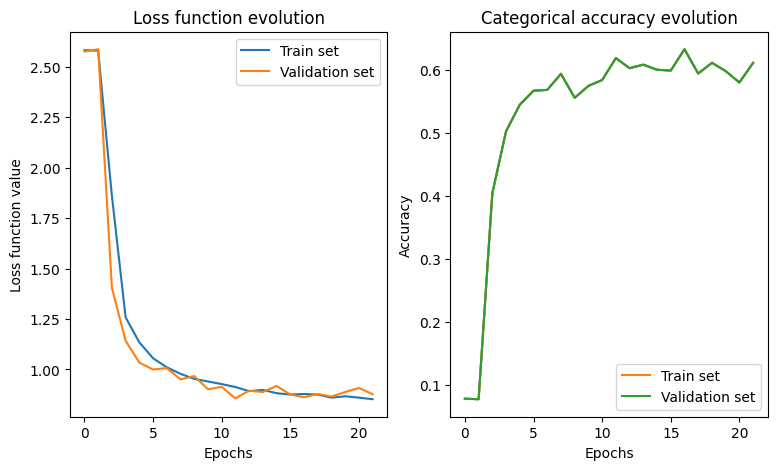

In [18]:
# Plot the loss function and accuracy evolution

loss_evolution = learning.history["loss"]
val_loss_evolution = learning.history["val_loss"]
acc_evolution = learning.history['val_categorical_accuracy']
val_acc_evolution = learning.history['val_categorical_accuracy']

plt.figure(figsize = (9,5))
plt.subplot(121)
plt.plot(loss_evolution,label = "Train set")
plt.plot(val_loss_evolution,label = "Validation set")
plt.xlabel("Epochs")
plt.ylabel("Loss function value")
plt.legend()
plt.title("Loss function evolution")

plt.subplot(122)
plt.plot(acc_evolution)
plt.plot(acc_evolution,label = "Train set")
plt.plot(val_acc_evolution,label = "Validation set")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Categorical accuracy evolution")

print("Total training time:", training_time, "seconds")
print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])

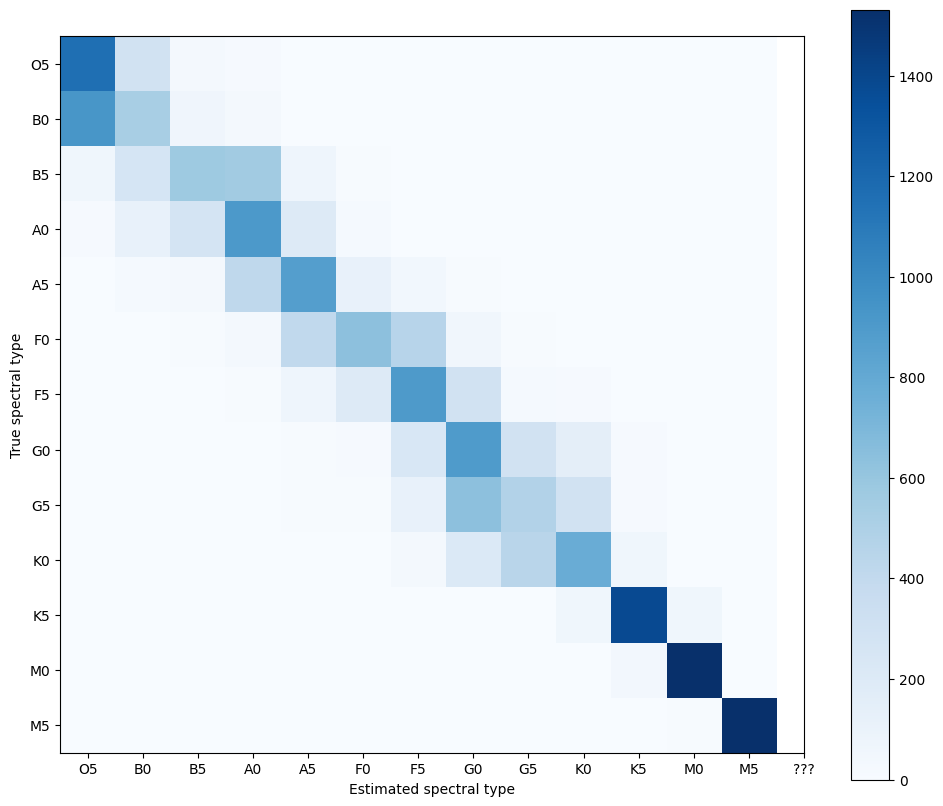

In [17]:
# Plot the confusion matrix

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

plt.figure(figsize= (12,10))
heatmap = plt.imshow(confusion_matrix[:13,:], cmap='Blues')
plt.xticks(np.arange(14), star_class_labels + ['???'])
plt.yticks(np.arange(13), star_class_labels)
plt.colorbar(heatmap)
plt.xlabel("Estimated spectral type")
plt.ylabel("True spectral type")
plt.show()


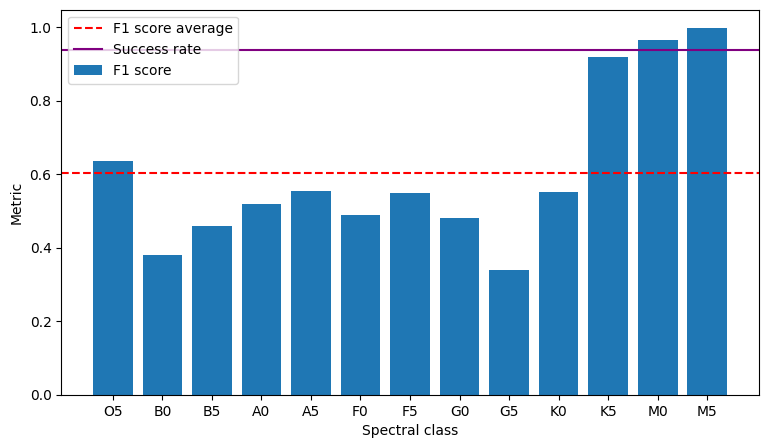

In [20]:
# Plot the metrics

plt.figure(figsize = (9,5))
plt.bar(np.arange(13), height = f1[:13], tick_label = star_class_labels ,label = "F1 score")
plt.axhline(f1_mean, color='red', linestyle='--', label = 'F1 score average')
plt.axhline(success_rate, color='purple', label = 'Success rate')
plt.xlabel("Spectral class")
plt.ylabel("Metric")
plt.legend()
plt.show()
